In [1]:
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import plotly_express as px
import plotly.io as pio
from sklearn import preprocessing
import pandas_profiling
import datetime
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt 
from sklearn import preprocessing
import warnings
import math
import plotly.express as px
import statsmodels
import scipy
import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


import math


warnings.filterwarnings("ignore")

# scipy
print('scipy: %s' % scipy.__version__)
# numpy
print('numpy: %s' % np.__version__)
# matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
print('pandas: %s' % pd.__version__)
# scikit-learn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
print('statsmodels: %s' % statsmodels.__version__)
#print('unicodedata: %s' % unicodedata.__version__)

scipy: 1.4.1
numpy: 1.18.2
matplotlib: 3.2.1
pandas: 1.0.3
sklearn: 0.22.2.post1
statsmodels: 0.11.1


In [2]:
#verificar feriados 
def isHoliday(dia,mes):
    if dia == 1:
        if mes == 1 or mes ==5:
            return(True)
    if (dia ==2 or dia==15) and mes==11:
        return(True)
    if (dia ==7 or dia==20) and mes == 9:
        return(True)
    if mes == 4 and dia==21:
        return(True)    
    if mes==10 and (dia==12):
        return(True)
    if mes==12 and (dia ==25 or dia ==24):
        return(True)
    if mes==12 and dia==31:
        return(True)
    return(False)   

def AdjustFeriado(x):
    #print(x)
    if x['Feriado'] == 0 or x['Feriado'] == 1:
        return(x['Feriado'])
       # print('else')
       # print(x['Feriado'] >=0)
    else:
        dia = x['judgmentDate'].day
        mes = x['judgmentDate'].month 
        feriado = 0 if isHoliday(dia,mes) == True else 1
        return(feriado)
    
def AdjustWeekDay(x):    
    if x['weekDay'] > 0:
        return(x['weekDay'])
    else:
        return(x['judgmentDate'].weekday())        
    
def AdjustWeekType(x):    
    if x['weekType'] > 0:
        return(x['weekType'])
    else:
        weekType = 1 if x['judgmentDate'].weekday() <5 else 0
        return(weekType)     

In [3]:
from statsmodels.tsa.stattools import adfuller

def adf_teste(series,title='',prints=False):    
    summay = ''
    if prints:
        print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC',) 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():        
        out[f'critical value ({key})']=val
        
    if prints:
        display(pd.DataFrame(out))
    
    
    
    if result[1] <= 0.05:
        summary = "Strong evidence against the null hypothesis \n Reject the null hypothesis \n Data has no unit root and is stationary"
        if prints:
            print("Strong evidence against the null hypothesis")
            print("Reject the null hypothesis")
            print("Data has no unit root and is stationary")        
    else:
        summary = "Weak evidence against the null hypothesis \n Fail to reject the null hypothesis \n Data has a unit root and is non-stationary"
        if prints:
            print("Weak evidence against the null hypothesis")
            print("Fail to reject the null hypothesis")
            print("Data has a unit root and is non-stationary")
            
    
    return(result[1],title,result[0],result[2],result[3],result[4],result[5],summary) 

In [4]:
#carrega
df_count_day_type = pd.read_csv('./data_joao/df_count_day_type_modificado.csv',sep=",")#,parse_dates=['judgmentDate'])
df_count_week_day_type = pd.read_csv('./data_joao/df_count_week_day_type_modificado.csv',sep=",")
df_count_year_month_type = pd.read_csv('./data_joao/df_count_year_month_type_modificado.csv',sep=",")

dfUniqueTypes = df_count_day_type['type'].unique()

#cria indice
df_count_day_type.index = pd.to_datetime(df_count_day_type['judgmentDate'])
df_count_year_month_type.index = pd.to_datetime(df_count_year_month_type['yearMonth'])

#deleta colunas que sobraram da importacao e da criacao do indice
del df_count_day_type['Unnamed: 0']
del df_count_week_day_type['Unnamed: 0']
del df_count_year_month_type['Unnamed: 0']
del df_count_day_type['judgmentDate']
del df_count_year_month_type['yearMonth']

#calcula o total do dia
df_count_day_type['total'] = df_count_day_type.groupby(['judgmentDate'])['count'].agg('sum')
#salva as informacoes que nao serao pivotadas
ref = df_count_day_type[['weekDay','weekType','Feriado','total']]
#realiza o pivot
df_count_day_typeGRP = df_count_day_type.pivot(columns='type', values='count').fillna(0)

#transforma tudo pra int (count)
for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)
        
#faz o merge com as que foram salvas antes do pivot        
df_count_day_typeGRP = pd.merge(df_count_day_typeGRP,ref,on='judgmentDate',how='left')
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate').drop_duplicates()

#remove duplicadas e nulas pra fazer a frequencia diaria
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP = df_count_day_typeGRP.drop_duplicates()
df_count_day_typeGRP = df_count_day_typeGRP.dropna()


df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP['Feriado'].apply( lambda x: 0 if x==True else 1)
df_count_day_typeGRP['weekType'] = pd.get_dummies(df_count_day_typeGRP['weekType'])
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D') #precisa pois abaixo seto os que faltam

#reseta o indice agora com todos os dias inclusive vazios e seta as informaçoes das datas novas (sem dados)
df_count_day_typeGRP = df_count_day_typeGRP.reset_index()    
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP.apply(AdjustFeriado,axis=1)
df_count_day_typeGRP['weekDay'] = df_count_day_typeGRP.apply(AdjustWeekDay,axis=1)
df_count_day_typeGRP['weekType'] = df_count_day_typeGRP.apply(AdjustWeekType,axis=1)

#volta ao estado normal (com indice e frequencia)
df_count_day_typeGRP.index = df_count_day_typeGRP['judgmentDate']
del df_count_day_typeGRP['judgmentDate']
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D')

#seta para zerado as datas que nao existiam antes 
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)

for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)


In [5]:
df_count_day_typeGRP.head(3)
df = df_count_day_typeGRP
dfMonth = df.resample('MS').sum()
dfQuarter = df.resample('QS').sum()
dfYear = df.resample('Y').sum()

field = 'total'

In [6]:
#display(dfYear.head(3))
#display(df.head(3))

In [7]:
import rpy2
print(rpy2.__version__)
from rpy2.robjects import default_converter,pandas2ri,r
from rpy2.robjects.conversion import Converter, localconverter
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
display(dfMonth.head(3))

3.3.1


,Agravo,Agravo Embargos Infringentes,Agravo Inominado,Agravo Interno,Agravo Lei,Agravo Regimental,Agravo de Instrumento,Agravo de Instrumento em Recurso Extraordinario,Agravo de Petição,Agravo em Execução,...,Suspenção de Liminar ou Antecipação de Tutela,Termo Circunstanciado,Tutela Antecipada Antecedente,Tutela Cautelar Antecedente,Tutela Provisoria,Uniformização de Jurisprudência,weekDay,weekType,Feriado,total
judgmentDate,,,,,,,,,,,,,,,,,,,,,
2000-01-01,0,0,0,0,0,0,10,0,0,0,...,0,0,0,0,0,0,84,21,29,10
2000-02-01,4,0,0,0,0,2,35,0,0,0,...,0,0,0,0,0,0,85,21,29,222
2000-03-01,17,0,0,3,0,6,93,0,0,0,...,0,0,0,0,0,0,93,23,31,573


In [58]:
base = importr('nnet')
base = importr('forecast')
base = importr('base')
utils = importr('utils')
jurimetrics = importr('jurimetrics')
ts=robjects.r('ts')
pandas2ri.activate()

rdata = ts((dfMonth['total']),frequency=12)


In [59]:
print(rdata)

[   10   222   573   647  1096  2305   106  4739  3297  4252  5012  4817
   218  3150  4820  4050  5865  5078   194  6265  3955  4809  5340  5365
   215  3179  4781  4796  5959  6057   287  5908  5057  8063  9573 13298
  1293  8723 12637 14255 14238 16933   940 18846 17194 20102 18524 20433
   751 11127 24716 20642 20483 25485  3686 23936 23296 21311 21964 25785
   760 11994 26246 22406 21805 29089 18017 26008 23608 22111 25290 25721
 15787 12213 27047 25328 28464 28649 22993 34297 26984 28524 32321 31973
  7169 21817 34138 29548 34845 30626 26790 36762 30165 34081 32252 29623
 12768 20184 32806 34018 33240 35535 34171 45409 38260 45858 39740 33540
 18200 17440 43019 43078 35647 41233 38555 42815 43665 40694 39818 32885
 22973 20858 43875 38866 44801 37568 39299 40296 38921 38601 39372 34987
 20010 27159 37784 36447 38160 42315 35954 44572 40665 37855 37036 34253
 17162 24362 42806 37693 45831 40865 32236 45652 34610 43379 37580 32606
 16334 21951 38773 39890 38111 39808 31729 41833 36

In [78]:
juriResult[0][9]

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,  3497.69910733,  4575.72464496,
        4395.53614821,  5454.67565815,   677.77880585,  5806.70810404,
        4990.9511426 ,  5724.47199323,  6181.14244818,  6616.52502702,
         676.49615152,  3844.86054709,  6074.46877226,  4502.01437976,
        6022.06988848,  6134.54936545,  -406.06148285,  6369.62152317,
        5017.31544957,  6807.63866242,  8379.58200141, 11081.0677126 ,
        1692.62777026,  8448.09642753, 11913.80426457, 13983.92417064,
       14592.10674864, 16801.97410676,  1712.86027683, 17442.9822842 ,
       16693.59823001, 20157.91364509, 18553.97343186, 21124.45124704,
         356.01738826, 12654.23663757, 24430.73359825, 20754.8604289 ,
       20392.32455748, 25676.53498596,  4324.40568493, 23752.89474314,
      

## MODO 1

In [60]:
juriResult = jurimetrics.fits(rdata, train=0.8,PI=False)

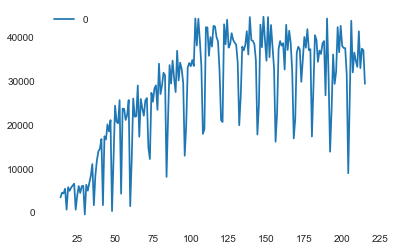

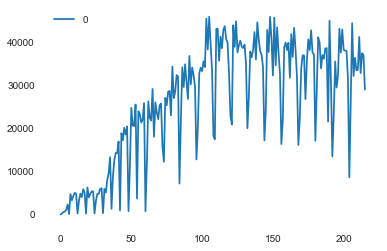

In [82]:
pd.DataFrame(juriResult[0][9]).plot(legend=True)
pd.DataFrame(rdata).plot(legend=True)
#base.

In [62]:
count =0
for i in juriResult[0]:    
    print('----------'+ str(count) +'----------')    
    print(i)    
    count=count+ 1

R[write to console]: Error in forecast::nnetar(y = x) : objeto 'x' não encontrado



----------0----------
[   10   222   573   647  1096  2305   106  4739  3297  4252  5012  4817
   218  3150  4820  4050  5865  5078   194  6265  3955  4809  5340  5365
   215  3179  4781  4796  5959  6057   287  5908  5057  8063  9573 13298
  1293  8723 12637 14255 14238 16933   940 18846 17194 20102 18524 20433
   751 11127 24716 20642 20483 25485  3686 23936 23296 21311 21964 25785
   760 11994 26246 22406 21805 29089 18017 26008 23608 22111 25290 25721
 15787 12213 27047 25328 28464 28649 22993 34297 26984 28524 32321 31973
  7169 21817 34138 29548 34845 30626 26790 36762 30165 34081 32252 29623
 12768 20184 32806 34018 33240 35535 34171 45409 38260 45858 39740 33540
 18200 17440 43019 43078 35647 41233 38555 42815 43665 40694 39818 32885
 22973 20858 43875 38866 44801 37568 39299 40296 38921 38601 39372 34987
 20010 27159 37784 36447 38160 42315 35954 44572 40665 37855 37036 34253
 17162 24362 42806 37693 45831 40865 32236 45652 34610 43379 37580 32606
 16334 21951 38773 39890 3811

RRuntimeError: Error in forecast::nnetar(y = x) : objeto 'x' não encontrado


In [ ]:
count = 0
for i in juriResult[1]:    
    print('----------'+ str(count) +'----------')    
    print(i)    
    count=count+ 1

In [ ]:
count = 0
display(juriResult[1])
for i in juriResult[1]:    
    print('----------'+ str(count) +'----------')    
    print(i)    
    count=count+ 1

In [ ]:
count = 0
for i in juriResult[2]:    
    print('----------'+ str(count) +'----------')    
    print(i)    
    count=count+ 1

In [ ]:
count = 0
for i in juriResult[3]:    
    print('----------'+ str(count) +'----------')    
    print(i)    
    count=count+ 1

In [ ]:
#Não sei se estão certos esses nomes (pred,fcast,original)

pd.Series(juriResult[0][9]).rename('pred').plot(legend=True,figsize=(25,8))
pd.Series(juriResult[0][10]).rename('fcast').plot(legend=True)
pd.Series(juriResult[0][0]).rename('original').plot(legend=True)
#pd.Series(rdata).rename('original').plot(legend=True)


## MODO 2


In [17]:
rdata = ts((dfQuarter['total']),frequency=12)


lenData = len(rdata)
testPercent = 0.8
testSize = int(lenData * testPercent)

print(lenData,testSize)

robjects.globalenv['r_timeseries'] = rdata[:testSize]
robjects.globalenv['r_timeseriesAll'] = rdata

#pred = robjects.r('as.data.frame(forecast(auto.arima(r_timeseries),h=5))')
#pred
robjects.r('library(jurimetrics)')
pred = robjects.r('(auto.arima(r_timeseries))')
#print(pred)
#print('1--------')
pred2 = robjects.r('(forecast::nnetar(r_timeseries))')
#print(pred2)

#print('AutoArima')
predAutoArima = robjects.r('as.data.frame(forecast::forecast(forecast::auto.arima(r_timeseries)))')
#print(predAutoArima)
#print('NNETAR')
predNNetar = robjects.r('as.data.frame(forecast::forecast(forecast::nnetar(r_timeseries)))')
#print(predNNetar)
#print('TBATS')
predTbats = robjects.r('as.data.frame(forecast::forecast(forecast::tbats(r_timeseries)))')
#print(predTbats)
#print('ETS')
predEts = robjects.r('as.data.frame(forecast::forecast(forecast::ets(r_timeseries)))')
#print(predEts)

fcastAutoArima = robjects.r('as.data.frame(forecast::forecast(forecast::auto.arima(r_timeseriesAll)))')
fcastNNetar = robjects.r('as.data.frame(forecast::forecast(forecast::nnetar(r_timeseriesAll)))')
fcastTbats = robjects.r('as.data.frame(forecast::forecast(forecast::tbats(r_timeseriesAll)))')
fcastEts = robjects.r('as.data.frame(forecast::forecast(forecast::ets(r_timeseriesAll)))')

#print(fcastEts)

72 57


Index(['Point Forecast', 'Lo 80', 'Hi 80', 'Lo 95', 'Hi 95'], dtype='object')


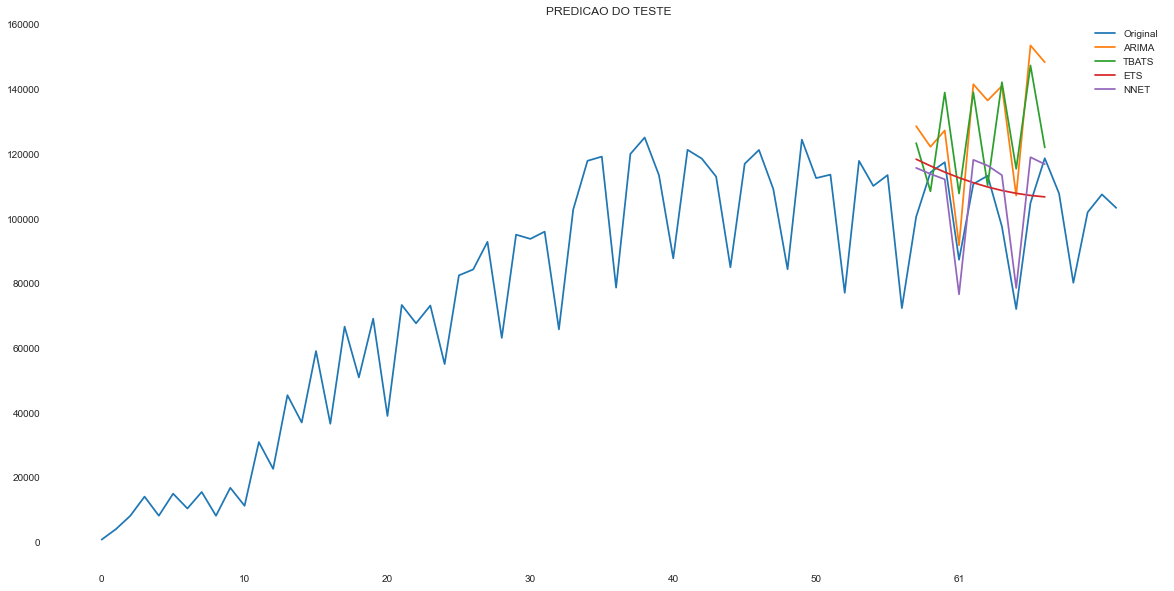

In [18]:
xttt = pd.Series(np.zeros(testSize).fill(np.nan),np.arange(0,testSize))
print(predAutoArima.columns)
predAutoArimaG = pd.concat([xttt,predAutoArima['Hi 80']])
predTbatsG = pd.concat([xttt,predTbats['Hi 80']])
predEtsG = pd.concat([xttt,predEts['Hi 80']])
predNNetarG = pd.concat([xttt,predNNetar['Point Forecast']])

pd.Series(rdata).rename('Original').plot(legend=True,title='PREDICAO DO TESTE',figsize=(20,10))
predAutoArimaG.rename('ARIMA').plot(legend=True)
predTbatsG.rename('TBATS').plot(legend=True)
predEtsG.rename('ETS').plot(legend=True)
predNNetarG.rename('NNET').plot(legend=True)

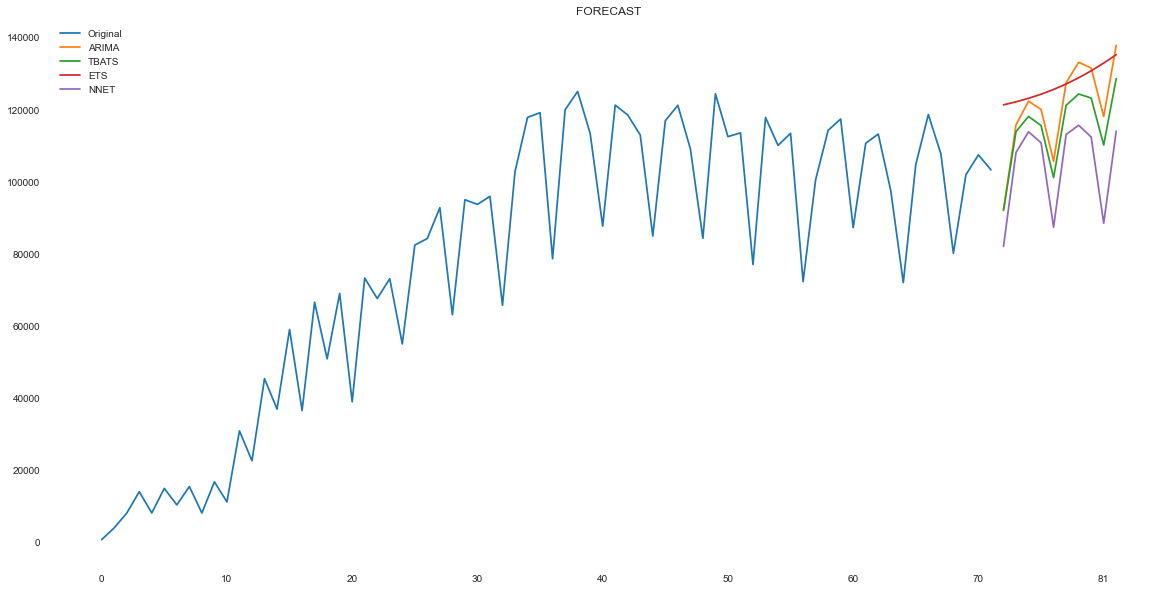

In [19]:
xttt = pd.Series(np.zeros(lenData).fill(np.nan),np.arange(0,lenData))
#print(xttt)
fcastAutoArimaG = pd.concat([xttt,fcastAutoArima['Hi 80']])
fcastTbatsG = pd.concat([xttt,fcastTbats['Hi 80']])
fcastEtsG = pd.concat([xttt,fcastEts['Hi 80']])
fcastNNetarG = pd.concat([xttt,fcastNNetar['Point Forecast']])

pd.Series(rdata).rename('Original').plot(legend=True,title='FORECAST',figsize=(20,10))
fcastAutoArimaG.rename('ARIMA').plot(legend=True)
fcastTbatsG.rename('TBATS').plot(legend=True)
fcastEtsG.rename('ETS').plot(legend=True)
fcastNNetarG.rename('NNET').plot(legend=True)

#display(pd.DataFrame(fcastNNetarG).tail(20))